In [12]:
# Advanced Time Series Forecasting with Deep Learning and Explainability using an LSTM model.

In [13]:
# ============================================================
# Advanced Time Series Forecasting with LSTM and SHAP
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import shap

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [14]:
# ------------------------------------------------------------
# 1. Generate a synthetic multivariate time series dataset
# ------------------------------------------------------------
def generate_synthetic_multivariate_series(n_timesteps=6000):
    """
    Create a synthetic multivariate time series with trends,
    seasonality, and noise.
    
    Returns:
        df: pandas DataFrame with columns:
            ['feature_temp', 'feature_volume', 'feature_noise', 'target']
    """
    t = np.arange(n_timesteps)

    # Feature 1: Slowly increasing trend + seasonality
    temp = 0.01 * t + 2 * np.sin(2 * np.pi * t / 50) + np.random.normal(scale=0.5, size=n_timesteps)

    # Feature 2: Seasonality with different frequency
    volume = 5 * np.sin(2 * np.pi * t / 100) + np.random.normal(scale=1.0, size=n_timesteps)

    # Feature 3: Mostly noise
    noise_feature = np.random.normal(scale=2.0, size=n_timesteps)

    # Target depends on past values of features
    target = (
        0.6 * temp +
        0.3 * volume +
        0.1 * noise_feature +
        np.random.normal(scale=0.5, size=n_timesteps)
    )

    data = {
        "feature_temp": temp,
        "feature_volume": volume,
        "feature_noise": noise_feature,
        "target": target,
    }

    df = pd.DataFrame(data)
    return df

df = generate_synthetic_multivariate_series()
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (6000, 4)
   feature_temp  feature_volume  feature_noise    target
0      0.248357       -1.114081       2.349628  0.210670
1      0.191534       -0.316978      -3.757962 -0.746648
2      0.841224       -0.315394      -0.655590  0.690235
3      1.527764        0.388911      -0.083320  0.729819
4      0.886431        1.029299       0.031817  1.218607


In [15]:
# ------------------------------------------------------------
# 2. Preprocessing: scaling, windowing, train/val/test split
# ------------------------------------------------------------

# Features and target
FEATURE_COLUMNS = ["feature_temp", "feature_volume", "feature_noise"]
TARGET_COLUMN = "target"

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[FEATURE_COLUMNS + [TARGET_COLUMN]])
scaled_df = pd.DataFrame(
    scaled_features,
    columns=FEATURE_COLUMNS + [TARGET_COLUMN]
)

def create_windowed_dataset(data, feature_cols, target_col, window_size=30, horizon=1):
    """
    Convert a time series into windowed samples:
    X: [samples, timesteps, features]
    y: [samples,]
    """
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        window = data[feature_cols].iloc[i : i + window_size].values
        target = data[target_col].iloc[i + window_size + horizon - 1]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

WINDOW_SIZE = 30
HORIZON = 1

X, y = create_windowed_dataset(
    scaled_df,
    feature_cols=FEATURE_COLUMNS,
    target_col=TARGET_COLUMN,
    window_size=WINDOW_SIZE,
    horizon=HORIZON,
)

print("X shape:", X.shape)  # (samples, timesteps, features)
print("y shape:", y.shape)

# Train/validation/test split
# First split into train + temp, then temp -> val + test
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

print("Train:", X_train_full.shape, "Val:", X_val.shape, "Test:", X_test.shape)


X shape: (5970, 30, 3)
y shape: (5970,)
Train: (4179, 30, 3) Val: (895, 30, 3) Test: (896, 30, 3)


In [16]:
# ------------------------------------------------------------
# 3. Build LSTM model + simple hyperparameter search
# ------------------------------------------------------------

def build_lstm_model(
    input_shape,
    lstm_units=64,
    dense_units=32,
    dropout_rate=0.2,
    learning_rate=1e-3
):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation="relu"))
    model.add(Dense(1))  # Regression output

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss="mse",
        optimizer=optimizer,
        metrics=["mae"]
    )
    return model

# Hyperparameter grids (keep small for demo; can expand for more exhaustive search)
lstm_units_list = [32, 64]
learning_rates = [1e-3, 5e-4]
dropout_rates = [0.2, 0.3]

best_val_rmse = float("inf")
best_config = None
best_model = None

EPOCHS = 15
BATCH_SIZE = 64

input_shape = (X_train_full.shape[1], X_train_full.shape[2])

for lstm_units in lstm_units_list:
    for lr in learning_rates:
        for dr in dropout_rates:
            print(f"\nTraining model with units={lstm_units}, lr={lr}, dropout={dr}")
            model = build_lstm_model(
                input_shape=input_shape,
                lstm_units=lstm_units,
                dense_units=32,
                dropout_rate=dr,
                learning_rate=lr
            )

            history = model.fit(
                X_train_full, y_train_full,
                validation_data=(X_val, y_val),
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                verbose=0
            )

            # Compute validation RMSE
            val_preds = model.predict(X_val, verbose=0)
            val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))

            print(f"Validation RMSE: {val_rmse:.4f}")

            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_config = {
                    "lstm_units": lstm_units,
                    "learning_rate": lr,
                    "dropout_rate": dr,
                }
                best_model = model

print("\nBest config:", best_config)
print("Best validation RMSE:", best_val_rmse)


Training model with units=32, lr=0.001, dropout=0.2


C:\Users\rohit\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation RMSE: 0.1234

Training model with units=32, lr=0.001, dropout=0.3


C:\Users\rohit\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation RMSE: 0.1905

Training model with units=32, lr=0.0005, dropout=0.2


C:\Users\rohit\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation RMSE: 0.1630

Training model with units=32, lr=0.0005, dropout=0.3


C:\Users\rohit\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation RMSE: 0.1532

Training model with units=64, lr=0.001, dropout=0.2


C:\Users\rohit\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation RMSE: 0.0775

Training model with units=64, lr=0.001, dropout=0.3


C:\Users\rohit\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation RMSE: 0.0764

Training model with units=64, lr=0.0005, dropout=0.2


C:\Users\rohit\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation RMSE: 0.1224

Training model with units=64, lr=0.0005, dropout=0.3


C:\Users\rohit\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation RMSE: 0.1692

Best config: {'lstm_units': 64, 'learning_rate': 0.001, 'dropout_rate': 0.3}
Best validation RMSE: 0.07641575629031638


In [17]:
# ------------------------------------------------------------
# 4. Final evaluation on test set
# ------------------------------------------------------------
test_preds = best_model.predict(X_test, verbose=0)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_mae = mean_absolute_error(y_test, test_preds)

print("\nTest RMSE:", test_rmse)
print("Test MAE:", test_mae)


Test RMSE: 0.11236933744378826
Test MAE: 0.09219349818115033


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/50 [00:00<?, ?it/s]

SHAP values computed using KernelExplainer.

Mean |SHAP| Feature Importance:
  feature_temp: 0.0957
  feature_volume: 0.0000
  feature_noise: 0.0000


C:\Users\rohit\AppData\Local\Temp\ipykernel_14468\751322682.py:43: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test_samples)
C:\Users\rohit\tfenv\lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


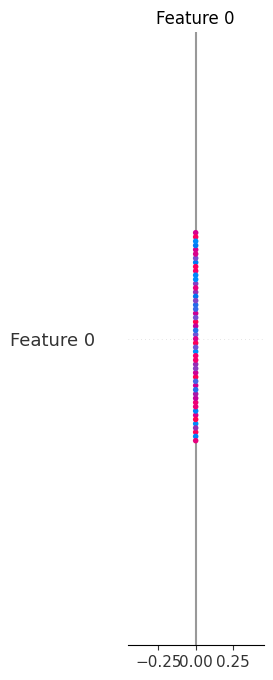

In [18]:
# ------------------------------------------------------------
# 5. SHAP Explainability (KernelExplainer - fully compatible)
# ------------------------------------------------------------
import shap

# KernelExplainer requires samples in 2D, so reshape:
X_train_kernel = X_train_full.reshape((X_train_full.shape[0], -1))
X_test_kernel = X_test.reshape((X_test.shape[0], -1))

# Define a prediction function that accepts 2D input
def predict_kernel(x):
    x_reshaped = x.reshape((x.shape[0], WINDOW_SIZE, len(FEATURE_COLUMNS)))
    return best_model.predict(x_reshaped, verbose=0)

# Use a small background dataset to keep SHAP fast
background = X_train_kernel[:200]

explainer = shap.KernelExplainer(predict_kernel, background)

# Compute SHAP values for 50 test samples
test_samples = X_test_kernel[:50]
shap_values = explainer.shap_values(test_samples)

print("SHAP values computed using KernelExplainer.")

# -------- Feature Importance (averaged across time steps) ------
shap_array = np.array(shap_values)
# shap_array shape → (1, samples, features_flat)

# Reshape back: (samples, timesteps, features)
shap_array = shap_array.reshape(
    50, WINDOW_SIZE, len(FEATURE_COLUMNS)
)

# Mean importance across samples + time
mean_abs_shap = np.mean(np.abs(shap_array), axis=(0, 1))

print("\nMean |SHAP| Feature Importance:")
for feat, val in zip(FEATURE_COLUMNS, mean_abs_shap):
    print(f"  {feat}: {val:.4f}")

# ----- Optional Summary Plot (stable for KernelExplainer) ------
shap.summary_plot(shap_values, test_samples)


In [19]:
# ------------------------------------------------------------
# 6. Utility: simple prediction demo for the latest window
# ------------------------------------------------------------
def predict_next_step(model, scaled_df, feature_cols, window_size=30):
    last_window = scaled_df[feature_cols].iloc[-window_size:].values
    last_window = np.expand_dims(last_window, axis=0)
    pred_scaled = model.predict(last_window, verbose=0)[0][0]
    # Inverse transform only target: build dummy row
    dummy = np.zeros((1, len(feature_cols) + 1))
    dummy[0, -1] = pred_scaled
    inv = scaler.inverse_transform(dummy)
    return inv[0, -1]

next_value = predict_next_step(best_model, scaled_df, FEATURE_COLUMNS, WINDOW_SIZE)
print("\nPredicted next-step (original scale) target value:", next_value)



Predicted next-step (original scale) target value: 34.04927729845361
